# Import Packages

In [2]:
# built-in
from ast import literal_eval
import itertools
import os.path

# third-party (pip install required)
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
from pymodulon.io import load_json_model
from scipy.stats import mannwhitneyu, pearsonr
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm import tqdm_notebook as tqdm

# set matplotlib params
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

# Load Data

In [3]:
P1K_PATH = '../../data/precise1k/'
FIG_PATH = 'investigate_expression_figs/'
ANNOTATION_PATH = '../../data/annotation/'

In [4]:
p1k = load_json_model(os.path.join(P1K_PATH, 'precise1k.json.gz'))
p1k_sample_table = p1k.sample_table
log_tpm = pd.read_csv(os.path.join(P1K_PATH, 'log_tpm_qc.csv'), index_col=0)

# Replicate Correlations

Generate plot comparing correlations of replicates to non-replicates in log_tpm values

In [144]:
rep_corrs = []
rand_corrs = []

num_comparisons = (p1k.sample_table.shape[0] * (p1k.sample_table.shape[0] - 1)) / 2
for exp1, exp2 in tqdm(itertools.combinations(p1k.sample_table.index, 2), total=num_comparisons):
    corr = pearsonr(log_tpm[exp1], log_tpm[exp2])[0]
    if p1k.sample_table.loc[exp1, 'full_name'] == p1k.sample_table.loc[exp2, 'full_name']:
        rep_corrs.append(corr)
    else:
        rand_corrs.append(corr)

/var/folders/q2/bdjskmzs1n9fbb14bmvhdz500000gn/T/ipykernel_81005/2814919258.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for exp1, exp2 in tqdm(itertools.combinations(p1k.sample_table.index, 2), total=num_comparisons):


  0%|          | 0/533028.0 [00:00<?, ?it/s]

In [145]:
with open(os.path.join(FIG_PATH, 'rep_corrs.txt'), 'w') as f:
    f.write(str(rep_corrs))
with open(os.path.join(FIG_PATH, 'rand_corrs.txt'), 'w') as f:
    f.write(str(rand_corrs))

In [22]:
with open(os.path.join(FIG_PATH, 'rep_corrs.txt'), 'r') as f:
    rep_corrs = literal_eval(f.read())
with open(os.path.join(FIG_PATH, 'rand_corrs.txt'), 'r') as f:
    rand_corrs = literal_eval(f.read())

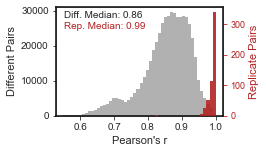

In [42]:
sns.set_style('ticks')

rand_color = 'darkgray'
rep_color = 'firebrick'

rep_median = np.median(rep_corrs)
rand_median = np.median(rand_corrs)

fig, ax = plt.subplots(figsize=(3,2))
ax2 = ax.twinx()
ax.hist(rand_corrs,bins=50,range=(0.55,1),alpha=0.9,color=rand_color,linewidth=0)
ax2.hist(rep_corrs,bins=50,range=(0.55,1),alpha=0.9,color=rep_color,linewidth=0)
ax.set_xlabel("Pearson's r",fontsize=11)
#ax.set_xticks(np.arange(0.4, 1.1, 0.1))
ax.set_ylabel('Different Pairs',fontsize=11)
ax.tick_params(axis='y', labelsize=10)
ax2.set_ylabel('Replicate Pairs',fontsize=11, color=rep_color)
ax2.tick_params(axis='y', colors=rep_color, labelsize=9)
ax.text(0.05, 0.9, f'Diff. Median: {rand_median:.2f}', transform=ax.transAxes, fontsize=10)
ax.text(0.05, 0.80, f'Rep. Median: {rep_median:.2f}', transform=ax.transAxes, color=rep_color, fontsize=10)
for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_PATH, 'replicate_correlations.svg'), bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'replicate_correlations.png'), bbox_inches='tight')

# PCA

In [5]:
pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(log_tpm.T), index=log_tpm.columns)
DF_components = pd.DataFrame(pca.components_.T, index=log_tpm.index)

## Explained Variance

Number of dimensions for 95% of variance: 130


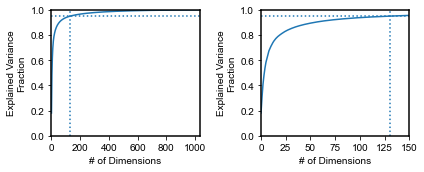

In [6]:
# Set the explained variance threshold
var_cutoff = 0.95

fig, (ax_all, ax_close) = plt.subplots(1, 2, figsize=(6,2.5))
pca_var = np.cumsum(pca.explained_variance_ratio_)
ax_all.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax_all.vlines(dims,0,1,linestyles='dotted')
ax_all.hlines(var_cutoff,0,len(log_tpm.columns),linestyles='dotted')
ax_all.set_ylim(0,1)
ax_all.set_xlim(0,len(log_tpm.columns))
ax_all.set_ylabel('Explained Variance\nFraction',fontsize=10)
ax_all.set_xlabel('# of Dimensions',fontsize=10)
ax_all.set_xticks(np.arange(0, 1100, 200))
for s in ax_all.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
    
ax_close.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax_close.vlines(dims,0,1,linestyles='dotted')
ax_close.hlines(var_cutoff,0,len(log_tpm.columns),linestyles='dotted')
ax_close.set_ylim(0,1)
ax_close.set_xlim(0,150)
ax_close.set_ylabel('Explained Variance\nFraction',fontsize=10)
ax_close.set_xlabel('# of Dimensions',fontsize=10)
ax_close.set_xticks(np.arange(0, 160, 25))
for s in ax_close.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
print(f'Number of dimensions for {var_cutoff*100:.0f}% of variance:', dims)
plt.tight_layout()

## First 2 Components: By Study

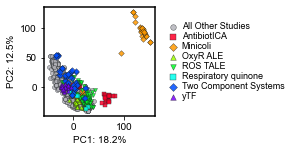

In [7]:
show_study = []
study_sort = []
for exp_id in p1k_sample_table.index:
    if p1k_sample_table.loc[exp_id, 'study'] in ['AntibiotICA', 'ROS TALE', 'Respiratory quinone',
                                           'Two Component Systems', 'yTF',                                         
                                          'Minicoli', 'OxyR ALE']:
        show_study.append(p1k_sample_table.loc[exp_id, 'study'])
        study_sort.append(0)
    else:
        show_study.append('All Other Studies')
        study_sort.append(1)
        
p1k_sample_table['show_study'] = show_study
p1k_sample_table['study_sort'] = study_sort
p1k_sample_table = p1k_sample_table.sort_values(by = ['study_sort', 'show_study'], ascending = [False,True])

NUM_COLORS = len(p1k_sample_table.groupby('show_study')) 
cm = pylab.get_cmap('gist_rainbow')
colors = ['#B4B4BB']+[cm(1.*i/(NUM_COLORS-1)) for i in range(0,NUM_COLORS-1)]
marker_list = ["o", "s", "D", "^", "v","s", "D", "^", "v", "s", "D", "^", "v","s", "D", "^", "v"]
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

fig,ax = plt.subplots(figsize=(2,2))

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)

for i,(name,group) in enumerate(p1k_sample_table.groupby('show_study', sort=False)):
    idx = log_tpm.loc[:,group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights.loc[idx,0],
               DF_weights.loc[idx,1],
               label=name,alpha=0.85, color=colors[i],marker=marker_list[i], s=16, linewidths =.4, edgecolors='#1C2021')
ax.set_xlabel('PC1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=10)
ax.set_ylabel('PC2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=10)
plt.legend(bbox_to_anchor=(1,0.5),loc='center left',fontsize=9,ncol=1, markerscale=1.4, columnspacing=0.1, handletextpad=.01,
          frameon=False, labelspacing=0.11)
plt.savefig(os.path.join(FIG_PATH, 'pca_components_study.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(os.path.join(FIG_PATH, 'pca_components_study.png'), dpi = 600, bbox_inches = 'tight')

## First 2 Components: By Creator

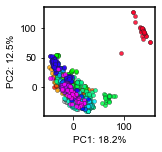

In [8]:
NUM_COLORS = len(p1k_sample_table.groupby('creator')) 
cm = pylab.get_cmap('gist_rainbow')
colors = ['#B4B4BB']+[cm(1.*i/(NUM_COLORS-1)) for i in range(0,NUM_COLORS-1)]
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

fig,ax = plt.subplots(figsize=(2,2))

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)

for i, (creator,creator_group) in enumerate(p1k_sample_table.groupby('creator')):
    idx = log_tpm.loc[:,creator_group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights.loc[idx,0],
               DF_weights.loc[idx,1],
               label=name,alpha=0.85, color=colors[i],s=16, linewidths =.4, edgecolors='#1C2021')
ax.set_xlabel('PC1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=10)
ax.set_ylabel('PC2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=10)
plt.savefig(os.path.join(FIG_PATH, 'pca_components_creator.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(os.path.join(FIG_PATH, 'pca_components_creator.png'), dpi = 600, bbox_inches = 'tight')

## w/o Minicoli

In [9]:
p1k_sample_table_no_mc = p1k_sample_table[p1k_sample_table['study'] != 'Minicoli'].copy()
log_tpm_no_mc = log_tpm[p1k_sample_table_no_mc.index]

pca_no_mc = PCA()
DF_weights_no_mc = pd.DataFrame(pca_no_mc.fit_transform(log_tpm_no_mc.T), index=log_tpm_no_mc.columns)
DF_components_no_mc = pd.DataFrame(pca_no_mc.components_.T, index=log_tpm_no_mc.index)

Number of dimensions for 95% of variance: 147


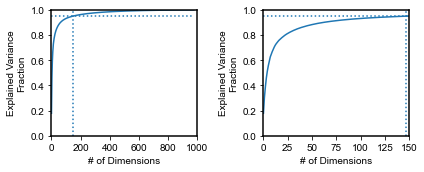

In [10]:
# Set the explained variance threshold
var_cutoff = 0.95

fig, (ax_all, ax_close) = plt.subplots(1, 2, figsize=(6,2.5))
pca_var = np.cumsum(pca_no_mc.explained_variance_ratio_)
ax_all.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax_all.vlines(dims,0,1,linestyles='dotted')
ax_all.hlines(var_cutoff,0,len(log_tpm_no_mc.columns),linestyles='dotted')
ax_all.set_ylim(0,1)
ax_all.set_xlim(0,len(log_tpm_no_mc.columns))
ax_all.set_ylabel('Explained Variance\nFraction',fontsize=10)
ax_all.set_xlabel('# of Dimensions',fontsize=10)
ax_all.set_xticks(np.arange(0, 1100, 200))
for s in ax_all.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
    
ax_close.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax_close.vlines(dims,0,1,linestyles='dotted')
ax_close.hlines(var_cutoff,0,len(log_tpm_no_mc.columns),linestyles='dotted')
ax_close.set_ylim(0,1)
ax_close.set_xlim(0,150)
ax_close.set_ylabel('Explained Variance\nFraction',fontsize=10)
ax_close.set_xlabel('# of Dimensions',fontsize=10)
ax_close.set_xticks(np.arange(0, 160, 25))
for s in ax_close.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
print(f'Number of dimensions for {var_cutoff*100:.0f}% of variance:', dims)
plt.tight_layout()

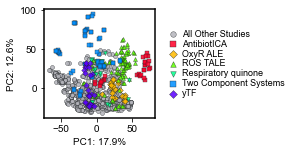

In [11]:
show_study = []
study_sort = []
for exp_id in p1k_sample_table_no_mc.index:
    if p1k_sample_table_no_mc.loc[exp_id, 'study'] in ['AntibiotICA', 'ROS TALE', 'Respiratory quinone',
                                           'Two Component Systems', 'yTF',                                         
                                          'Minicoli', 'OxyR ALE']:
        show_study.append(p1k_sample_table_no_mc.loc[exp_id, 'study'])
        study_sort.append(0)
    else:
        show_study.append('All Other Studies')
        study_sort.append(1)
        
p1k_sample_table_no_mc['show_study'] = show_study
p1k_sample_table_no_mc['study_sort'] = study_sort
p1k_sample_table_no_mc = p1k_sample_table_no_mc.sort_values(by = ['study_sort', 'show_study'], ascending = [False,True])

NUM_COLORS = len(p1k_sample_table_no_mc.groupby('show_study')) 
cm = pylab.get_cmap('gist_rainbow')
colors = ['#B4B4BB']+[cm(1.*i/(NUM_COLORS-1)) for i in range(0,NUM_COLORS-1)]
marker_list = ["o", "s", "D", "^", "v","s", "D", "^", "v", "s", "D", "^", "v","s", "D", "^", "v"]
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

fig,ax = plt.subplots(figsize=(2,2))

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)

for i,(name,group) in enumerate(p1k_sample_table_no_mc.groupby('show_study', sort=False)):
    idx = log_tpm_no_mc.loc[:,group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights_no_mc.loc[idx,0],
               DF_weights_no_mc.loc[idx,1],
               label=name,alpha=0.85, color=colors[i],marker=marker_list[i], s=16, linewidths =.4, edgecolors='#1C2021')
ax.set_xlabel('PC1: %.1f%%'%(pca_no_mc.explained_variance_ratio_[0]*100),fontsize=10)
ax.set_ylabel('PC2: %.1f%%'%(pca_no_mc.explained_variance_ratio_[1]*100),fontsize=10)
plt.legend(bbox_to_anchor=(1,0.5),loc='center left',fontsize=9,ncol=1, markerscale=1.4, columnspacing=0.1, handletextpad=.01,
          frameon=False, labelspacing=0.11)
plt.savefig(os.path.join(FIG_PATH, 'pca_components_study_no_minicoli.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(os.path.join(FIG_PATH, 'pca_components_study_no_minicoli.png'), dpi = 600, bbox_inches = 'tight')

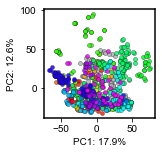

In [12]:
NUM_COLORS = len(p1k_sample_table_no_mc.groupby('creator')) 
cm = pylab.get_cmap('gist_rainbow')
colors = ['#B4B4BB']+[cm(1.*i/(NUM_COLORS-1)) for i in range(0,NUM_COLORS-1)]
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

fig,ax = plt.subplots(figsize=(2,2))

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)

for i, (creator,creator_group) in enumerate(p1k_sample_table_no_mc.groupby('creator')):
    idx = log_tpm_no_mc.loc[:,creator_group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights_no_mc.loc[idx,0],
               DF_weights_no_mc.loc[idx,1],
               label=name,alpha=0.85, color=colors[i],s=16, linewidths =.4, edgecolors='#1C2021')
ax.set_xlabel('PC1: %.1f%%'%(pca_no_mc.explained_variance_ratio_[0]*100),fontsize=10)
ax.set_ylabel('PC2: %.1f%%'%(pca_no_mc.explained_variance_ratio_[1]*100),fontsize=10)
plt.savefig(os.path.join(FIG_PATH, 'pca_components_creator_no_minicoli.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(os.path.join(FIG_PATH, 'pca_components_creator_no_minicoli.png'), dpi = 600, bbox_inches = 'tight')

# Gene Expression Breakdowns

In [5]:
gene_table = pd.read_csv(os.path.join(ANNOTATION_PATH, 'gene_info.csv'), index_col=0)
gene_table_w_ex = gene_table[gene_table['p1k_log_tpm_med'].notna()]
gene_table_w_ex = gene_table_w_ex.assign(proteomics=gene_table_w_ex.apply(lambda row: row[['schmidt_prot_med', 'heckmann_prot_med']].notna().any(), axis=1))
gene_table_w_ex.head()

,gene_name,synonyms,gene_product,COG,regulator,uniprot,start,end,strand,in_iM,...,MS57,pseudogene,y_ome,k_eff,schmidt_prot_med,heckmann_prot_med,p1k_ctrl_log_tpm,p1k_log_tpm_med,p1k_log_tpm_med_abs_dev,proteomics
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0002,thrA,thrA;thrA1;thrA2,fused aspartate kinase/homoserine dehydrogenase 1,Amino acid transport and metabolism,"RpoD,Ile-tRNA,Thr-tRNA,DksA,Fnr,ArcA,ppGpp",P00561,337,2799,+,True,...,True,False,False,True,4101.5,4434.0,10.314562,9.601212,0.703939,True
b0003,thrB,thrB,homoserine kinase,Nucleotide transport and metabolism,"RpoD,Ile-tRNA,Thr-tRNA,DksA,ppGpp",P00547,2801,3733,+,True,...,True,False,False,True,442.0,1177.0,9.982251,9.219235,0.701042,True
b0004,thrC,thrC,threonine synthase,Amino acid transport and metabolism,"RpoD,ppGpp,Ile-tRNA,Thr-tRNA,DksA",P00934,3734,5020,+,True,...,True,False,False,True,8818.5,3516.0,9.973666,9.270352,0.618962,True
b0005,yaaX,yaaX,DUF2502 domain-containing protein YaaX,Function unknown,Lrp,P75616,5234,5530,+,True,...,True,False,True,False,NaN,NaN,7.132482,6.281161,0.731280,False
b0006,yaaA,yaaA,peroxide stress resistance protein YaaA,Function unknown,NaN,P0A8I3,5683,6459,-,True,...,True,False,True,True,539.5,333.0,6.494941,6.345154,0.306394,True


## Statistical Comparisons

Running Mann-Whitney U tests for the medians of categories plotted below

In [6]:
cols = ['in_iM', 'iML1515', 'y_ome', 'proteomics', 'core_genome']

stats_df = pd.DataFrame(columns=['n_yes', 'n_no', 'U', 'P', 'U_mad', 'P_mad'])

for col in cols:
    yes_log_tpm_meds = gene_table_w_ex[gene_table_w_ex[col]]['p1k_log_tpm_med'].values
    no_log_tpm_meds = gene_table_w_ex[~gene_table_w_ex[col]]['p1k_log_tpm_med'].values
    n_yes = len(yes_log_tpm_meds)
    n_no = len(no_log_tpm_meds)
    U, p = mannwhitneyu(yes_log_tpm_meds, no_log_tpm_meds)
    yes_log_tpm_mads = gene_table_w_ex[gene_table_w_ex[col]]['p1k_log_tpm_med_abs_dev'].values
    no_log_tpm_mads = gene_table_w_ex[~gene_table_w_ex[col]]['p1k_log_tpm_med_abs_dev'].values
    U_mad, p_mad = mannwhitneyu(yes_log_tpm_mads, no_log_tpm_mads)
    stats_df.loc[col] = [n_yes, n_no, U, p, U_mad, p_mad]
    
stats_df

,n_yes,n_no,U,P,U_mad,P_mad
in_iM,2499.0,1712.0,2172234.0,3.931662e-01,3405132.0,4.253024e-234
iML1515,1512.0,2699.0,2333279.0,1.015230e-14,2201736.0,2.028980e-05
y_ome,1438.0,2773.0,1328146.0,8.109902e-71,2122903.0,5.580945e-04
proteomics,2031.0,2180.0,3917744.0,0.000000e+00,2191058.0,5.641947e-01
core_genome,356.0,3855.0,1161825.0,3.837730e-104,509500.0,8.249209e-16


## Function: plot_expression_by_boolean_category

In [108]:
def plot_jointgrid(genes, color, title, filename):
    g = sns.JointGrid(data=gene_table_w_ex.loc[genes], x='p1k_log_tpm_med',y='p1k_log_tpm_med_abs_dev',
                      xlim=(0, 15), ylim=(0, 3),
                      height=1.5, marginal_ticks=False)
    g.plot_joint(sns.scatterplot, s=5, c=[color])
    g.plot_marginals(sns.boxplot, color=color, fliersize=0.5, linewidth=0.5)

    g.ax_joint.set_xlabel('Median log[TPM]', fontsize=8)
    g.ax_joint.set_ylabel('MAD log[TPM]', fontsize=8)
    g.ax_joint.set_xticks(np.arange(0, 20, 5))
    for s in g.ax_joint.spines.values():
        s.set_visible(True)
        s.set_color('k')
        s.set_linewidth(0.9)
        
    g.ax_marg_x.set_title(f'{title} (n={len(genes)})', fontsize=10)

    for s in (list(g.ax_marg_x.spines.values()) + list(g.ax_marg_y.spines.values())):
        s.set_visible(False)
        
    plt.savefig(os.path.join(FIG_PATH, f'{filename}.png'), bbox_inches='tight', dpi=400)
    plt.savefig(os.path.join(FIG_PATH, f'{filename}.svg'), bbox_inches='tight', dpi=400)

def plot_expression_by_boolean_category(bool_col, filename_prefix, title_base, title_negate='not'):
    
    # get the yes/no genes from the category column
    yes_genes = gene_table_w_ex[gene_table_w_ex[bool_col]].index
    no_genes = gene_table_w_ex[~gene_table_w_ex[bool_col]].index
    
    plot_jointgrid(yes_genes, 'steelblue', title_base, f'{filename_prefix}_yes')
    plot_jointgrid(no_genes, 'firebrick', f'{title_negate} {title_base}', f'{filename_prefix}_no')

## iModulon Membership

/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout()
/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout()


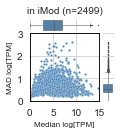

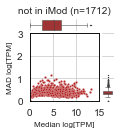

In [109]:
plot_expression_by_boolean_category('in_iM', 'im_membership', 'in iMod')

## iML1515

/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout()
/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout()


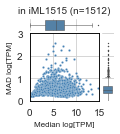

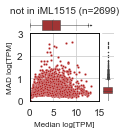

In [110]:
plot_expression_by_boolean_category('iML1515', 'iML1515', 'in iML1515')

## y-ome

/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout()
/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout()


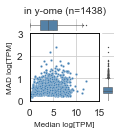

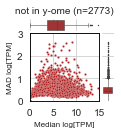

In [111]:
plot_expression_by_boolean_category('y_ome', 'y_ome', 'in y-ome')

## Proteomics

/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout()
/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout()


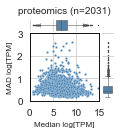

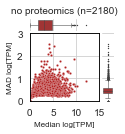

In [112]:
plot_expression_by_boolean_category('proteomics', 'proteomics', 'proteomics', title_negate='no')

## Core Genome

/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout()
/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout()


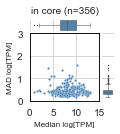

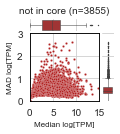

In [113]:
plot_expression_by_boolean_category('core_genome', 'core_genome', 'in core')

## COG

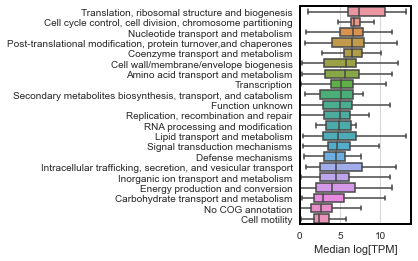

In [46]:
sns.set_style('whitegrid')
_, ax = plt.subplots(figsize=(2, 4))
sns.boxplot(y='COG', x='p1k_log_tpm_med', data=gene_table_w_ex,
            order=gene_table_w_ex.groupby('COG').median().sort_values('p1k_log_tpm_med', ascending=False).index,
            orient='h', showfliers=False,
           ax=ax)

ax.set_xlabel('Median log[TPM]', fontsize=11)
ax.set_ylabel('')
ax.set_xlim(0, ax.get_xlim()[1])

for s in ax.spines.values():
    s.set_linewidth(2)
    s.set_color('k')
    
plt.savefig(os.path.join(FIG_PATH, 'by_cog.png'), bbox_inches='tight', dpi=400)
plt.savefig(os.path.join(FIG_PATH, 'by_cog.svg'), bbox_inches='tight', dpi=400)